Introduction
============

Recently, I started using the [pandas](http://pandas.pydata.org/) python library to improve the quality 
(and quantity) of statistics in my applications. One method that has helped me much is the `pivot_table`
command. This is a really (at least for me) complicated command that has
[very poor documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html).
Beyond this, this command is explained a little more in an article about 
[data reshaping](http://pandas.pydata.org/pandas-docs/stable/reshaping.html), however, even this leaves
much to be desired (when I first tried reading it I was overwhelmed by the amount of information there).

A great introduction to pandas is the [three part series](http://www.gregreda.com/2013/10/26/intro-to-pandas-data-structures/) by Greg Reda - it touches `pivot_table` however I was only able to understand it properly *after* I played a lot with it. I don't know, maybe playing with `pivot_table` yourself (or being really experienced in such concepts) is the only way to properly comprehend it -- however I'm going to try to explain it a bit here in small steps.

I have to mention that I am no expert in statistics or
numeric analysis so this post won't have any advanced 
information and may even point out some obvious things. However
keep in mind things that may seem obvious to some
experts are really difficult to grasp for a non-expert.

Before continuing, please notice that this article has been written as a [jupyter notebook](http://jupyter.org/) and was integrated with pelican using the [pelican-ipynb plugin](https://github.com/danielfrg/pelican-ipynb). I had to do some modifications to my theme to better integrate the notebook styling, however some stuff may not look as nice as the other articles. I have to mention that this integration is really great and I totally recommend it!

The DataFrame
=============

The most important data structure that pandas uses is the [DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). This can be thought as a two dimensional array, something like an Excel spreadsheet. In the pandas nomenclature, the rows of that two-dimensional array are called *indexes* (while the columns keep their name) -- I'll either use rows or indexes for the rows. However please notice that pandas has a different data structure named [Index](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Index.html) that is used to store the names of the headers (axis) of the rows and columns.

If we horizontally/vertically pick the values of a single row(index)/column we'll be left with a different data structure called [Series](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html) - this is more or less a single dimensional array. There's also a [Panel](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Panel.html) data structure which is 3-dimensional, more like a complete Excel workbook (the third dimension being the individual sheets of the workbook) but I won't cover that here.

More info on the above can be found on the corresponding [article about data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html).

There are various ways to read the data for a Series or DataFrame: Initializing through [arrays or dicts](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_records.html), [reading from csv](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_csv.html), [xls](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html), [database](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_query.html), combinining series to create an array and various others. I won't go into any details about this but will include some examples on how to create Series and DataFrames.

Before continuing with more info on the `pivot_table` operation, I will list a number of examples as a quick reference on how to work with Series and DataFrames that will be useful in the rest of the article (and should be useful in general). Notice that I'm using pandas 0.18.1.

Using Series
------------

The `Series` data structure is more oor less used to store a single dimensional array of data. This array-like structure could either have numbers as indexes (so will be more similar to a normal array) or have textual indexes (so will be more similar to a dictionary). Let's see some examples:

In [1]:
import pandas as pd

def t(o):
    # Return the class name of the object
    return o.__class__.__name__

# Use an array to create a Series
series1 = pd.Series([10,20,30])
print "series1 (", t(series1), ')\n', series1
# Notice that the index names were automatically generated as 0,1,2
# Use a dict to create a Series
# notice that the keys of the dict will be the index names
series2 = pd.Series({'row1':11,'row2':22,'row3':33})
print "series2 (", t(series2), ')\n', series2

series1 ( Series )
0    10
1    20
2    30
dtype: int64
series2 ( Series )
row1    11
row2    22
row3    33
dtype: int64


The are various ways to select values from the Series. You can use textual or numeric indexes or you can filter the elements using an intuitive syntax:

In [71]:
# Get values from series using named indexes
series2['row1']
# Can also use slicing and interesting operations 
# like array in array [[]] to select specific indexes
print series1[1:]
print series1[[0,2]]
print series2['row2':]
print series2[['row1', 'row3']]

1    20
2    30
dtype: int64
0    10
2    30
dtype: int64
row2    22
row3    33
dtype: int64
row1    11
row3    33
dtype: int64


In [81]:
# Filtering series
# You can use comparison operators with a Series to 
# get an array of booleans with the result of each element
print "Boolean result\n", series2>15
# This can then be used to filter the Series:
print "Filtered result\n", series2[series2>15]

Boolean result
row1    False
row2     True
row3     True
dtype: bool
Filtered result
row2    22
row3    33
dtype: int64


In [3]:
# Filtering can be generalized - just pass an array of booleans
print "Boolean filtering\n", series2[[True, False,True]]
# The above means that we want only the first and third (index: 0,2) elements of the Series

# So we can create a function that returns Boolean, apply it to 
# all elements of series with map and use the result for indexing!
def is_22(x):
    return x==22
print "Map filtering\n", series2[series2.map(is_22)]

Boolean filtering
row1    11
row3    33
dtype: int64
Map filtering
row2    22
dtype: int64


The `map` method above gets a callback function and applies it to all elements of the Series, returning a new Series with the results. It is similar to the `map(function, sequence) -> list` global python funtion.

Using DataFrames
----------------

Let's start by a quick introduction to see some basic operations on DataFrames:

In [5]:
# Create a DataFrame using a two-dimensional array
# Notice that the indexes and column names were automatically generated
df1 = pd.DataFrame([[10,20,30], [40,50,60]])
print "Dataframe from array: df1(", t(df1), ')'
print df1

# Use a dict to give names to 
df2 = pd.DataFrame([{'col1':10,'col2':20,'col3':30}, {'col1':40,'col2':50,'col3':60}])
print "Dataframe from dict: df2(", t(df2), ')'
print df2

# Give names to indexes
df3 = pd.DataFrame([
    {'col1':10,'col2':20,'col3':30}, 
    {'col1':40,'col2':50,'col3':60}
], index=['idx1', 'idx2'])
print "Dataframe from dict, named indexes: df3(", t(df3), ')'
print df3

# What happens when columns are missing
df4 = pd.DataFrame([{'col1':10,'col2':20,'col3':30}, {'col2':40,'col3':50,'col4':60}])
print "Dataframe from dict, missing columns: df4(", t(df4), ')'
print df4

# Create a DataFrame by combining series
df5 = pd.DataFrame([pd.Series([1,2]), pd.Series([3,4])], index=['a', 'b'], )
print "Dataframe from series: df5(", t(df5), ')'
print df5

# Output a dataframe as html
print df5.to_html()

# Notice that there are many more interesting DataFrame output methods, like
# to_csv, to_dict, to_excel, to_json, to_latex, to_msgpack, to_string,

 Dataframe from array: df1( DataFrame )
    0   1   2
0  10  20  30
1  40  50  60
Dataframe from dict: df2( DataFrame )
   col1  col2  col3
0    10    20    30
1    40    50    60
Dataframe from dict, named indexes: df3( DataFrame )
      col1  col2  col3
idx1    10    20    30
idx2    40    50    60
Dataframe from dict, missing columns: df4( DataFrame )
   col1  col2  col3  col4
0  10.0    20    30   NaN
1   NaN    40    50  60.0
Dataframe from series: df5( DataFrame )
   0  1
a  1  2
b  3  4
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>0</th>
      <th>1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>a</th>
      <td>1</td>
      <td>2</td>
    </tr>
    <tr>
      <th>b</th>
      <td>3</td>
      <td>4</td>
    </tr>
  </tbody>
</table>


Selecting values from the Dataframe is also easy if you know how to do it. You index (`[]`) directly to select columns or you use the `loc/iloc` rows/indexes of the `DataFrame` to select 

In [14]:
print "df3(", t(df3), ")\n", df3

# We can get a column as a Series
print "Get column as series\n", df3['col3']
df3.ix[0]

# Or multiple columns as a DataFrame
print "Get multiple columns\n", df3[['col3', 'col2']]

# We can also get the column by its idx
print "Get column by index\n", df3[df3.columns[2]]

# Pick an index (select horizontal line) as a series
print "Get index as a series\n", df3.loc['idx1']

# Also can pick by index number
print "Get index as a series by index\n", df3.iloc[0]

# Pick values from a dataframe using array indexing
# This returns a Series which will re-index to get the value
print "Get value\n", df3['col2']['idx2']

df3( DataFrame )
      col1  col2  col3
idx1    10    20    30
idx2    40    50    60
Get column as series
idx1    30
idx2    60
Name: col3, dtype: int64
Get multiple columns
      col3  col2
idx1    30    20
idx2    60    50
Get column by index
idx1    30
idx2    60
Name: col3, dtype: int64
Get index as a series
col1    10
col2    20
col3    30
Name: idx1, dtype: int64
Get index as a series by index
col1    10
col2    20
col3    30
Name: idx1, dtype: int64
Get value
50


In [51]:
# iloc can be used to numerically index both rows and columns by passing two indexes:
print df3.iloc[0] # get the first row/index - this is the same as df3.iloc[0, :]
# so to select the first column we'll use
print df3.iloc[:, 0]
# We could do more interesting things:
print df3.iloc[0:2, 0:2]
# Loc (which is for label based indexing also gets two parameters)
df3.loc[['idx1','idx2'], 'col1']

col1    10
col2    20
col3    30
Name: idx1, dtype: int64
idx1    10
idx2    40
Name: col1, dtype: int64
      col1  col2
idx1    10    20
idx2    40    50


idx1    10
idx2    40
Name: col1, dtype: int64

Of course, boolean indexing and filtering can also be used just like in Series:

In [52]:
print "Boolean dataframe\n", df3>=30
print "Boolean indexing\n",df3[df3>=30]
def is_20_or_40(x):
    return x==20 or x==40
# We need to use applymap (instead of map we used in Series)
print "Boolean indexing\n",df3[df3.applymap(is_20_or_40)]

Boolean dataframe
       col1   col2  col3
idx1  False  False  True
idx2   True   True  True
Boolean indexing
      col1  col2  col3
idx1   NaN   NaN    30
idx2  40.0  50.0    60
Boolean indexing
      col1  col2  col3
idx1   NaN  20.0   NaN
idx2  40.0   NaN   NaN


Notice that for the DataFrame we use the `applymap` method which applies the callback function to all individual elements of the  DataFrame and returns the result as a new  DataFrame (with the same dimensions of course).

Modifying DataFrames
--------------------

It's easy to modify the DataFrame by changing its values, adding more indexes / columns, dropping rows and columns, renaming columns and indexes. Notice that some operations are performed in place (so they modify the original DataFrame), while others return a copy of the original array.

In [65]:
# Let's copy because some of the following operators change the dataframes
df = df3.copy()
print df

print "Change values of a column"
df['col1'] = [11,41]
print df

print "Change values of an index"
df.loc['idx1'] = [11,21, 31]
print df

print "We can change more specific values (a 2x2 array here)"
df.iloc[0:2, 0:2] = [[4,3], [2,1]]
print df

print "Add another column to an existing dataframe (changes DataFrame)"
df['col4'] = [1,2]
print df

print "Add another row (index) to an existing dataframe (changes DataFrame)"
df.loc['idx3']=[100,200,300,400]
print df

print "Drop a row (returns new object)"
print df.drop('idx1')

print "Drop a column (returns new object)"
print df.drop('col1', axis=1)

print "Rename index (returns new object)"
print df.rename(index={'idx1': 'new-idx-1'})

print "Rename column (returns new object)"
print df.rename(columns={'col1': 'new-col-1'})

print "Transpose array- change columns to rows and vice versa"
print df.T

print "Double transpose - returns the initial DataFrame"
print df.T.T

      col1  col2  col3
idx1    10    20    30
idx2    40    50    60
Change values of a column
      col1  col2  col3
idx1    11    20    30
idx2    41    50    60
Change values of an index
      col1  col2  col3
idx1    11    21    31
idx2    41    50    60
We can change more specific values (a 2x2 array here)
      col1  col2  col3
idx1     4     3    31
idx2     2     1    60
Add another column to an existing dataframe (changes DataFrame)
      col1  col2  col3  col4
idx1     4     3    31     1
idx2     2     1    60     2
Add another row (index) to an existing dataframe (changes DataFrame)
      col1  col2  col3  col4
idx1     4     3    31     1
idx2     2     1    60     2
idx3   100   200   300   400
Drop a row (returns new object)
      col1  col2  col3  col4
idx2     2     1    60     2
idx3   100   200   300   400
Drop a column (returns new object)
      col2  col3  col4
idx1     3    31     1
idx2     1    60     2
idx3   200   300   400
Rename index (returns new object)
  

More advanced operations
------------------------

Beyond the previous, more or less basic operations, pandas allows you to do some advanced operations like SQL-like joins of more than one dataset or, applying a function to each of the rows / columns or even individual cells of the DataFrame:

In [69]:
authors_df=pd.DataFrame([{'id': 1, 'name':'Stephen King'}, {'id': 2, 'name':'Michael Crichton'}],  )

books_df=pd.DataFrame([
    {'id': 1, 'author_id':1, 'name':'It'}, 
    {'id': 2, 'author_id':1, 'name':'The Stand'}, 
    {'id': 3, 'author_id':2, 'name':'Airframe'},
    {'id': 4, 'author_id':2, 'name':'Jurassic Park'}
])

print authors_df
print books_df
print books_df.merge(authors_df, left_on='author_id', right_on='id')

   id              name
0   1      Stephen King
1   2  Michael Crichton
   author_id  id           name
0          1   1             It
1          1   2      The Stand
2          2   3       Airframe
3          2   4  Jurassic Park
   author_id  id_x         name_x  id_y            name_y
0          1     1             It     1      Stephen King
1          1     2      The Stand     1      Stephen King
2          2     3       Airframe     2  Michael Crichton
3          2     4  Jurassic Park     2  Michael Crichton


As can be seen above, the `merge` method of DataFrame can be used to do an sql-like join with another DataFrame, using specific columns as join-keys for each of the two dataframes (`left_on` and `right_on`). There are a lot of options for doing various join types (left, right, inner, outer etc) and concatenating DataFrames with other ways - most are discussed in the [corresponding post](http://pandas.pydata.org/pandas-docs/stable/merging.html).

Let's see another method of doing the above join that is more controlled, using the `apply` method of DataFrame that *applies* a function to each row/column of the DataFrame and returns the result as a series:

In [92]:
# Let's do the join using a different method
def f(r):
    author_df_partial = authors_df[authors_df.id==r['author_id']]
    return author_df_partial.iloc[0]['name']
        
books_df['author name'] = books_df.apply(f, axis=1)
print books_df

   author_id  id           name       author name
0          1   1             It      Stephen King
1          1   2      The Stand      Stephen King
2          2   3       Airframe  Michael Crichton
3          2   4  Jurassic Park  Michael Crichton


How does this work? We pass the `axis=1` parameter to `apply` so that the callback function will be called for each row of the DataFrame (by default `axis=0` which means it will be called for each column). So, `f` will be called getting each row as an input. From this `book_df` row, we get the `author_id` it contains and filter `authors_df` by it. Notice that `author_df_partial` is actually a DataFrame containing only one row, so we need to filter it by getting its only line, using `iloc[0]` which will return a Series and finally, we return the author name using the corresponding index `name`.

When calling the `apply` method, by defautl the `axis` parameter is 0 (i.e the function will be called for each column). When I first encountered this I found it very strange because I thought that most users would usually want to apply a function to each of the rows. However, there's a reason for applying the function to all columns, here's an example:

In [93]:
values = pd.DataFrame([
    {'temperature': 31, 'moisture': 68},
    {'temperature': 33, 'moisture': 72},
    {'temperature': 31.5, 'moisture': 58},
    {'temperature': 28.5, 'moisture': 42},
])

import numpy as np
# We can easily create statistics for our data using apply -- that's why
# axis=0 is the default parameter to apply (to operate vertically to each column)
values.loc['avg']=values.apply(np.average )
values.loc['len']=values.apply(len )
values.loc['sum']=values.apply(sum)
print values

     moisture  temperature
0        68.0         31.0
1        72.0         33.0
2        58.0         31.5
3        42.0         28.5
avg      60.0         31.0
len       5.0          5.0
sum     305.0        160.0


Comprehending `pivot_table`
=========================

After this (rather long) introduction to satellite methods of DataFrames, the time has come to see `pivot_table`. The `pivot_table` method is applied to a DataFrame and its purpose is to "reshape" and aggregate the values of a DataFrame . More on reshaping can be found [here](http://pandas.pydata.org/pandas-docs/stable/reshaping.html) it means changing the indexes/columns of the DataFrame. Aggregate means that for each of the new cells we'll create a summary of the data that should have appeared there.

Let's start by creating a nice set of data we'll use for the `pivot_table` operations:

In [96]:
books_df=pd.DataFrame([
    {'author':'Stephen King', 'name':'It', 'pages': 1138, 'year': 1986, 'genre': 'Horror',},  
    {'author':'Stephen King', 'name':'The Stand', 'pages': 823, 'year': 1978, 'genre': 'Horror',}, 
    {'author':'Stephen King', 'name': 'Salem\'s Lot', 'pages': 439, 'year': 1975, 'genre': 'Horror',},
    {'author':'Stephen King', 'name': 'Misery', 'pages': 320, 'year': 1987, 'genre': 'Thriller',},
    {'author':'Stephen King', 'name': 'Pet Sematary', 'pages': 374, 'year': 1983, 'genre': 'Horror',},
    {'author':'Stephen King', 'name': 'Bag of bones', 'pages': 529, 'year': 1998, 'genre': 'Horror',},
    {'author':'Stephen King', 'name': 'Different Seasons', 'pages': 527, 'year': 1982, 'genre': 'Thriller',},
    {'author':'Stephen King', 'name': 'The Dark Tower: The Gunslinger', 'pages': 224, 'year': 1982, 'genre': 'Fantasy',},
    {'author':'Stephen King', 'name': 'The Dark Tower II: The Drawing of the Three', 'pages': 400, 'year': 1987, 'genre': 'Fantasy',},
    {'author':'Stephen King', 'name': 'The Dark Tower III: The Waste Lands', 'pages': 512, 'year': 1991, 'genre': 'Fantasy',},
    {'author':'Stephen King', 'name': 'The Dark Tower IV: Wizard and Glass', 'pages': 787, 'year': 1998, 'genre': 'Fantasy',},
    {'author':'Michael Crichton', 'name':'Airframe', 'pages': 352, 'year': 1996, 'genre': 'Crime',},
    {'author':'Michael Crichton', 'name':'Jurassic Park', 'pages': 448, 'year':1990, 'genre': 'Fantasy',},
    {'author':'Michael Crichton', 'name':'Congo', 'pages': 348, 'year':1980, 'genre': 'Fantasy',},
    {'author':'Michael Crichton', 'name':'Sphere', 'pages': 385, 'year':1987, 'genre': 'Fantasy',},
    {'author':'Michael Crichton', 'name':'Rising Sun', 'pages': 385, 'year':1992, 'genre': 'Crime',},
    {'author':'Michael Crichton', 'name':'Disclosure ', 'pages': 597, 'year':1994, 'genre': 'Crime',},
    {'author':'Michael Crichton', 'name':'The Lost World ', 'pages': 430, 'year':1995, 'genre': 'Fantasy',},
    {'author':'John Grisham', 'name':'A Time to Kill', 'pages': 515, 'year':1989, 'genre': 'Crime',},
    {'author':'John Grisham', 'name':'The Firm', 'pages': 432, 'year':1991, 'genre': 'Crime',},
    {'author':'John Grisham', 'name':'The Pelican Brief', 'pages': 387, 'year':1992, 'genre': 'Crime',},
    {'author':'John Grisham', 'name':'The Chamber', 'pages': 496, 'year':1994, 'genre': 'Crime',},
    {'author':'John Grisham', 'name':'The Rainmaker', 'pages': 434, 'year':1995, 'genre': 'Crime',},
    {'author':'John Grisham', 'name':'The Runaway Jury', 'pages': 414, 'year':1996, 'genre': 'Crime',},
    {'author':'John Grisham', 'name':'The Street Lawyer', 'pages': 347, 'year':1998, 'genre': 'Crime',},
    {'author':'George Pelecanos', 'name':'Nick\'s Trip ', 'pages': 276, 'year':1993, 'genre': 'Crime',},
    {'author':'George Pelecanos', 'name':'A Firing Offense', 'pages': 216, 'year':1992, 'genre': 'Crime',},
    {'author':'George Pelecanos', 'name':'The Big Blowdown', 'pages': 313, 'year':1996, 'genre': 'Crime',},
    {'author':'George R.R Martin', 'name':'A Clash of Kings', 'pages': 768, 'year':1998, 'genre': 'Fantasy',},
    {'author':'George R.R Martin', 'name':'A Game of Thrones', 'pages': 694, 'year':1996, 'genre': 'Fantasy',},
])

# Add a decade column to the books DataFrame
def add_decade(y):
        return str(y['year'])[2] + '0\'s'
    
books_df['decade'] = books_df.apply(add_decade, axis=1)

# Add a size column to the books DataFrame
def add_size(y):
        if y['pages'] > 600:
            return 'big'
        elif y['pages'] < 300:
            return 'small'
        return 'medium'
    
books_df['size'] = books_df.apply(add_size, axis=1)
# Let's display it sorted here
books_df.sort_values(['decade', 'genre', 'year'])

,author,genre,name,pages,year,decade,size
2,Stephen King,Horror,Salem's Lot,439,1975,70's,medium
1,Stephen King,Horror,The Stand,823,1978,70's,big
18,John Grisham,Crime,A Time to Kill,515,1989,80's,medium
13,Michael Crichton,Fantasy,Congo,348,1980,80's,medium
7,Stephen King,Fantasy,The Dark Tower: The Gunslinger,224,1982,80's,small
8,Stephen King,Fantasy,The Dark Tower II: The Drawing of the Three,400,1987,80's,medium
14,Michael Crichton,Fantasy,Sphere,385,1987,80's,medium
4,Stephen King,Horror,Pet Sematary,374,1983,80's,medium
0,Stephen King,Horror,It,1138,1986,80's,big
6,Stephen King,Thriller,Different Seasons,527,1982,80's,medium


The recommended type of input (at least by me) to the `pivot_table` is a simple DataFrame like the one I have already created:  Your index will be the `id` of your database (or you could even have an auto-generated index like in the example) and the columns will be the values you want to create representations on. This is very easy to create either by reading a file (xls/csv) or by a simple SQL query (substituting all foreign keys with a representative value). In the above example, we actually have the following columns: *author, genre, name, pages, year, decade, size* - this is a pool of data that will be very useful to remember for later and it is important to also keep it in your mind for your data.

The [pivot_table method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) uses four basic parameters:

* `index`: An array of the data that will be used as indexes to the resulting DataFrame
* `columns`: An array of the data that will be used as a columns to the resulting DataFrame
* `values`: An array of the data whose values we want to aggregate in each cell
* `aggfunc`: Which is the function (or functions) that will be used for aggregating the values

So, how it actually works? You select a number of the headers from your pool of data and assign them to either `index` or `columns`, depending if you want to put them horizontally or vertically -- notice that both `index` and `columns` take either a string (to denote a single column) or an array to denote multiple columns, also both `index` and `columns` are optional (but you must define one of them). Multiple data headers means that you'll have [hierachical indexes / columns](http://pandas.pydata.org/pandas-docs/stable/advanced.html) in your pivot(or `MultiIndex` as it's called - remember that `Index` is used to store the axis of the DataFrame), ie the rows/columns would be grouped by a hierarchy. Please notice that the intersection of index and columns sets have to be an empty set (i.e you can't use the same data header in both). Let's see an example of multiple indexes:

If we used `'decade'` as an index, then the pivot_table index would be like 
* `70s` value1 value2 ...
* `80s` value1 value2 ...
* `90s` value1 value2 ...

while, if we used `['decade', 'year']` we'd hove something like

* `70s`
    * `1975` value1 value2 ...
    * `1978` value1 value2 ...
* `80s`
    * `1980` value1 value2 ...
    * `1982` value1 value2 ...
    * ...
* `90s`
    * `1990` value1 value2 ...
    * ... 
    
So, each year would automatically be grouped to its corresponing decade. The same would be true if we used `['decade', 'year']` in columns (but we'll now have a vertical grouping from top to bottom). Notice that pandas doesn't know if the values have any parent / child relationship but just goes from left to right (or top to bottom). For example, if we had used `['year', 'decade']`, we'd get something like:

* `1975 70s'` value1 value2 ... 
* `1978 70s'` value1 value2 ...
* `1980 80s'` value1 value2 ...	
* `1982 80s'` value1 value2 ...

Also, pandas doesn't care if the values of the hierarchical index are actually related. We could for example had selected a multi index of `['decade', 'size', 'genre']` that would display the list of decades at the left (or at the top if we used it as a column), for each decade will display the sizes of the book of that decade at the center and finally, at the right (or bottom correspondingly) will display the available genres for each size. So, since we have 3 values for each decade, 3 values for each size and 4 values for each genre in our dataset, each decade will appear 1 time (at the left), each size will appear 3 times (one for each decade) in the middle and each genre will appear 3x3 = 9(one for each combination of decade and size) times in the right. The total number of lines that our MultiIndex will be able to index is 3x3x4 = 36 (one line for each combination of decade/size/genre).

I hope the above clears out how index and columns are used to create the headers for rows and index of `pivot_table`. I will show some examples of various index and columns combinations but first, I'd like to talk about the actual values that the pivot table will contain (since we've only talked about the headers of rows/columns until now).

The values that the pivot_table will contain are defined through the other two parameters, `values` and `aggfunc`: We select one or more columns of the initial DataFrame through the `values` parameter and these are aggregated in the corresponding cell of the resulting dataframe using the aggfunc fuction -- for each index and column, we will pick the values correspond to that cell and pass them to a function that will return the result. that As can be understood, the values must be different than index and columns (so all three sets of values, index and columns must not intersect). By default, the `values` and `aggfunc` parameters may be ommited - this will result in using average as the function and selecting all numerical columns (that are not in indexes or columns of course) in the values.

I know that this is difficult to understand so I'll give a simple example right away. Let's say that we wanted to aggregate our books by their decade and genre:


In [97]:
books_df.pivot_table(index=['decade', ], columns=['genre'], )

pages                                 year                       \
genre        Crime Fantasy Horror Thriller        Crime      Fantasy  Horror   
decade                                                                         
70's           NaN     NaN  631.0      NaN          NaN          NaN  1976.5   
80's    515.000000  339.25  756.0    423.5  1989.000000  1984.000000  1984.5   
90's    387.416667  606.50  529.0      NaN  1994.083333  1994.666667  1998.0   

                 
genre  Thriller  
decade           
70's        NaN  
80's     1984.5  
90's        NaN

As we can see we just passed `decade` as an index and `genre` as a column. We ommited `values` and `aggfunc` so the default values were used. What happened? Pandas created a new DataFrame that had the values of decade as its index and the values of genre as its columns. Now, for each of the values (remember that since we ommited values, pandas just gets all numerical data, i.e pages and year) it found the corresponding entries for each cell, got their average and put it in that cell. For example, since there are no Crime genre books in the 70's we got a `NaN` to both the pages and year values. However, there are two Horror books, with 823 and 439 pages so their average is 631. The year column will also use the average, something that doesn't actually makes sense. So let's display only the pages:

In [98]:
books_df.pivot_table(index=['decade', ], columns=['genre'], values=['pages'])

pages                        
genre        Crime Fantasy Horror Thriller
decade                                    
70's           NaN     NaN  631.0      NaN
80's    515.000000  339.25  756.0    423.5
90's    387.416667  606.50  529.0      NaN

In [101]:
# Please notice that you can skip index or columns (but not both)
print books_df.pivot_table(index=['decade', ], values='pages')
print books_df.pivot_table(columns=['decade', ], values='pages')

decade
70's    631.000000
80's    470.111111
90's    464.052632
Name: pages, dtype: float64
decade
70's    631.000000
80's    470.111111
90's    464.052632
Name: pages, dtype: float64


Both of the above return a simple Series (that's why they are the same).

Let's now say that we actually wanted to have a meaningful value for the year, for example the first year we have a book for that genre/decade:

In [102]:
books_df.pivot_table(index=['decade', ], columns=['genre'], aggfunc=min )

author                                                 \
genre              Crime            Fantasy        Horror      Thriller   
decade                                                                    
70's                None               None  Stephen King          None   
80's        John Grisham   Michael Crichton  Stephen King  Stephen King   
90's    George Pelecanos  George R.R Martin  Stephen King          None   

                    name                                                     \
genre              Crime           Fantasy        Horror           Thriller   
decade                                                                        
70's                None              None   Salem's Lot               None   
80's      A Time to Kill             Congo            It  Different Seasons   
90's    A Firing Offense  A Clash of Kings  Bag of bones               None   

       pages                          year                            size  \
genre  Crime Fantasy Horror Thriller Crime Fantasy Horror Thriller   Crime   
decade                                                                       
70's    None    None    439     None  None    None   1975     None    None   
80's     515     224    374      320  1989    1980   1983     1982  medium   
90's     216     430    529     None  1991    1990   1998     None  medium   

                                 
genre  Fantasy  Horror Thriller  
decade                           
70's      None     big     None  
80's    medium     big   medium  
90's       big  medium     None

This is more interesting. It seems that since we didn't use the default aggfunc value but instead we passed our own (`min`), pandas did not use only the numerical values but used instead all remaining value columns: Remember that our pool of data was *author, genre, name, pages, year, decade, size*, the genre and decade were used as an index/column so the remaining headers were used as values: author, name, pages, year, size! For the pages and year we can understand what happens: For example, for the Horror novels of the 80's, the one with the minimal pages is Pet Sematery with 374 pages. The same has also the minimal year (1983).  However, the one with the minimal name is `It` (since `I` is before `P` it just compares strings). The author is the same for both(`Stephen King`) and the minimum size is medium (since `small (s) > medium (m)`). Of course we could pass the `values` parameter to actually define which values we wanted to see.

Another really interesting thing is to take a peek at which are the values that are passed to the aggregation function. For this, we can just use `tuple`:

In [104]:
# Please notice that for reasons unknown to me, if I used aggfunc=tuple it would throw an exception
books_df_tuples = books_df.pivot_table(index=['decade', ], columns=['genre'], aggfunc=lambda x: tuple(x))
books_df_tuples

author  \
genre                                               Crime   
decade                                                      
70's                                                 None   
80's                                      (John Grisham,)   
90's    (Michael Crichton, Michael Crichton, Michael C...   

                                                           \
genre                                             Fantasy   
decade                                                      
70's                                                 None   
80's    (Stephen King, Stephen King, Michael Crichton,...   
90's    (Stephen King, Stephen King, Michael Crichton,...   

                                                                    \
genre                         Horror                      Thriller   
decade                                                               
70's    (Stephen King, Stephen King)                          None   
80's    (Stephen King, Stephen King)  (Stephen King, Stephen King)   
90's                 (Stephen King,)                          None   

                                                     name  \
genre                                               Crime   
decade                                                      
70's                                                 None   
80's                                    (A Time to Kill,)   
90's    (Airframe, Rising Sun, Disclosure , The Firm, ...   

                                                           \
genre                                             Fantasy   
decade                                                      
70's                                                 None   
80's    (The Dark Tower: The Gunslinger, The Dark Towe...   
90's    (The Dark Tower III: The Waste Lands, The Dark...   

                                                               \
genre                     Horror                     Thriller   
decade                                                          
70's    (The Stand, Salem's Lot)                         None   
80's          (It, Pet Sematary)  (Misery, Different Seasons)   
90's             (Bag of bones,)                         None   

                                                    pages  \
genre                                               Crime   
decade                                                      
70's                                                 None   
80's                                               (515,)   
90's    (352, 385, 597, 432, 387, 496, 434, 414, 347, ...   

                                                                 \
genre                          Fantasy       Horror    Thriller   
decade                                                            
70's                              None   (823, 439)        None   
80's              (224, 400, 348, 385)  (1138, 374)  (320, 527)   
90's    (512, 787, 448, 430, 768, 694)       (529,)        None   

                                                     year  \
genre                                               Crime   
decade                                                      
70's                                                 None   
80's                                              (1989,)   
90's    (1996, 1992, 1994, 1991, 1992, 1994, 1995, 199...   

                                                                          \
genre                                Fantasy        Horror      Thriller   
decade                                                                     
70's                                    None  (1978, 1975)          None   
80's                (1982, 1987, 1980, 1987)  (1986, 1983)  (1987, 1982)   
90's    (1991, 1998, 1990, 1995, 1998, 1996)       (1998,)          None   

                                                     size  \
genre                                               Crime   
decade                                                 

In [105]:
# Dont worry about the ellipsis, the values are all there in each cell, for example
books_df_tuples['author']['Crime']['90\'s']

('Michael Crichton',
 'Michael Crichton',
 'Michael Crichton',
 'John Grisham',
 'John Grisham',
 'John Grisham',
 'John Grisham',
 'John Grisham',
 'John Grisham',
 'George Pelecanos',
 'George Pelecanos',
 'George Pelecanos')

In [106]:
# What if we wanted to only display the different authors for each genre and decade? Easy:
books_df.pivot_table(
    index=['decade', ], 
    columns=['genre'], 
    values='author',
    aggfunc=lambda x: tuple(set(x))
)

genre,Crime,Fantasy,Horror,Thriller
decade,,,,
70's,None,None,"(Stephen King,)",None
80's,"(John Grisham,)","(Stephen King, Michael Crichton)","(Stephen King,)","(Stephen King,)"
90's,"(John Grisham, Michael Crichton, George Peleca...","(Stephen King, George R.R Martin, Michael Cric...","(Stephen King,)",None


Notice that the inpout parameter that is passed to our aggunc is actually a `Series` so don't be alarmed if some list operations are not working:

In [109]:
books_df.pivot_table(
    index=['decade', ], 
    columns=['genre'], 
    values='author',
    aggfunc=lambda x: type(x)
)

genre,Crime,Fantasy,Horror,Thriller
decade,,,,
70's,None,None,<class 'pandas.core.series.Series'>,None
80's,<class 'pandas.core.series.Series'>,<class 'pandas.core.series.Series'>,<class 'pandas.core.series.Series'>,<class 'pandas.core.series.Series'>
90's,<class 'pandas.core.series.Series'>,<class 'pandas.core.series.Series'>,<class 'pandas.core.series.Series'>,None


Before continuing, I'd like to present another two parameters that could be passed to the pivot_table: `fill_value` to define a value to display when no values are found to be aggregated for a cell and `margins` to enable or disable margin rows/columns to the left/bottom that will aggregate all values of that column, for example:

In [110]:
books_df.pivot_table(
    index=['decade', ],
    columns=['genre'], values
    ='author', 
    aggfunc=lambda x: tuple(set(x)), 
    margins=True, 
    fill_value='-'
)

genre,Crime,Fantasy,Horror,Thriller,All
decade,,,,,
70's,-,-,"(Stephen King,)",-,"(Stephen King,)"
80's,"(John Grisham,)","(Stephen King, Michael Crichton)","(Stephen King,)","(Stephen King,)","(Stephen King, John Grisham, Michael Crichton)"
90's,"(John Grisham, Michael Crichton, George Peleca...","(Stephen King, George R.R Martin, Michael Cric...","(Stephen King,)",-,"(Stephen King, George R.R Martin, John Grisham..."
All,"(John Grisham, Michael Crichton, George Peleca...","(Stephen King, George R.R Martin, Michael Cric...","(Stephen King,)","(Stephen King,)","(Stephen King, George R.R Martin, John Grisham..."


Using our previous knowledge of multi column indexes, let's display the average number of pages each author writes for each decade and genre:

In [111]:
books_df.pivot_table(
    index=['decade', ],
    columns=['author', 'genre'], 
    values=['pages'], 
)

pages                                                  \
author George Pelecanos George R.R Martin John Grisham Michael Crichton   
genre             Crime           Fantasy        Crime            Crime   
decade                                                                    
70's                NaN               NaN          NaN              NaN   
80's                NaN               NaN   515.000000              NaN   
90's         268.333333             731.0   418.333333       444.666667   

                                             
author         Stephen King                  
genre  Fantasy      Fantasy Horror Thriller  
decade                                       
70's       NaN          NaN  631.0      NaN  
80's     366.5        312.0  756.0    423.5  
90's     439.0        649.5  529.0      NaN

In [15]:
# One interesting thing is that if we changed the order of the multi-columns we'd get the same data
books_df.pivot_table(
    index=['decade', ],
    columns=['genre', 'author'], 
    values=['pages'], 
)

pages                                                  \
genre             Crime                                         Fantasy   
author George Pelecanos John Grisham Michael Crichton George R.R Martin   
decade                                                                    
70's                NaN          NaN              NaN               NaN   
80's                NaN   515.000000              NaN               NaN   
90's         268.333333   418.333333       444.666667             731.0   

                                                                
genre                                      Horror     Thriller  
author Michael Crichton Stephen King Stephen King Stephen King  
decade                                                          
70's                NaN          NaN        631.0          NaN  
80's              366.5        312.0        756.0        423.5  
90's              439.0        649.5        529.0          NaN

In [16]:
# Or we can interchange index with columns to get the same data in a horizontal format
books_df.pivot_table(
    columns=['decade', ],
    index=['author', 'genre'], 
    values=['pages'], 
)

pages                   
decade                       70's   80's        90's
author            genre                             
George Pelecanos  Crime       NaN    NaN  268.333333
George R.R Martin Fantasy     NaN    NaN  731.000000
John Grisham      Crime       NaN  515.0  418.333333
Michael Crichton  Crime       NaN    NaN  444.666667
                  Fantasy     NaN  366.5  439.000000
Stephen King      Fantasy     NaN  312.0  649.500000
                  Horror    631.0  756.0  529.000000
                  Thriller    NaN  423.5         NaN

So, `Michael Crichton` was writing 445 pages for Crime novels and 439 pages for Fantasy novels on average at the 90's (of course this would be true if we had included all works of Michael Crichton).
In the previous table we can see that, for example for `George Pelecanos` only the `Crime` genre is displayed (since he's only Crime genre books in our database). Pandas automatically drops columns / lines where everything is empty -- if we for some reason wanted to display it, we'd use the `dropna=False` parameter:

In [113]:
books_df.pivot_table(
    index=['decade', ], 
    columns=['author', 'genre'], 
    values=['pages'], 
    dropna=False
)

pages                                                    \
author George Pelecanos                         George R.R Martin           
genre             Crime Fantasy Horror Thriller             Crime Fantasy   
decade                                                                      
70's                NaN     NaN    NaN      NaN               NaN     NaN   
80's                NaN     NaN    NaN      NaN               NaN     NaN   
90's         268.333333     NaN    NaN      NaN               NaN   731.0   

                                                                              \
author                 John Grisham                         Michael Crichton   
genre  Horror Thriller        Crime Fantasy Horror Thriller            Crime   
decade                                                                         
70's      NaN      NaN          NaN     NaN    NaN      NaN              NaN   
80's      NaN      NaN   515.000000     NaN    NaN      NaN              NaN   
90's      NaN      NaN   418.333333     NaN    NaN      NaN       444.666667   

                                                                     
author                         Stephen King                          
genre  Fantasy Horror Thriller        Crime Fantasy Horror Thriller  
decade                                                               
70's       NaN    NaN      NaN          NaN     NaN  631.0      NaN  
80's     366.5    NaN      NaN          NaN   312.0  756.0    423.5  
90's     439.0    NaN      NaN          NaN   649.5  529.0      NaN

In [112]:
# We can create any combination we want with our multi-index colums, for example let's see where each book belongs
# be decade / year / author and genre / size
books_df.pivot_table(
    index=['decade', 'year', 'author', 'name' ], 
    columns=['size', 'genre'], 
    values=['pages'], 
    aggfunc=lambda x: 'v',
    fill_value='',
)
# To remove the "pages" title, just index by it -- result['pages']

pages  \
size                                                                          big   
genre                                                                     Fantasy   
decade year author            name                                                  
70's   1975 Stephen King      Salem's Lot                                           
       1978 Stephen King      The Stand                                             
80's   1980 Michael Crichton  Congo                                                 
       1982 Stephen King      Different Seasons                                     
                              The Dark Tower: The Gunslinger                        
       1983 Stephen King      Pet Sematary                                          
       1986 Stephen King      It                                                    
       1987 Michael Crichton  Sphere                                                
            Stephen King      Misery                                                
                              The Dark Tower II: The Drawing of the Three           
       1989 John Grisham      A Time to Kill                                        
90's   1990 Michael Crichton  Jurassic Park                                         
       1991 John Grisham      The Firm                                              
            Stephen King      The Dark Tower III: The Waste Lands                   
       1992 George Pelecanos  A Firing Offense                                      
            John Grisham      The Pelican Brief                                     
            Michael Crichton  Rising Sun                                            
       1993 George Pelecanos  Nick's Trip                                           
       1994 John Grisham      The Chamber                                           
            Michael Crichton  Disclosure                                            
       1995 John Grisham      The Rainmaker                                         
            Michael Crichton  The Lost World                                        
       1996 George Pelecanos  The Big Blowdown                                      
            George R.R Martin A Game of Thrones                                 v   
            John Grisham      The Runaway Jury                                      
            Michael Crichton  Airframe                                              
       1998 George R.R Martin A Clash of Kings                                  v   
            John Grisham      The Street Lawyer                                     
            Stephen King      Bag of bones                                          
                              The Dark Tower IV: Wizard and Glass               v   

                                                                                  \
size                                                                               
genre                                                                     Horror   
decade year author            name                                                 
70's   1975 Stephen King      Salem's Lot                                          
       1978 Stephen King      The Stand                                        v   
80's   1980 Michael Crichton  Congo                                                
       1982 Stephen King      Different Seasons                                    
                              The Dark Tower: The Gunslinger                       
       1983 Stephen King      Pet Sematary                                         
       1986 Stephen King      It                                               v   
       1987 Michael Crichton  Sphere                                               
            Stephen King      Misery                                               
                              The Dark Tower II: The Drawing of the Three          
       19

One more advanced thing I'd like to cover here is that we could define multiple aggregate functions for each one of our values by passing a dictionary of `value:function` to the `aggfunc` parameter. For example, if we wanted to display 
* the sum of the pages that have been written
* the range of years for which we have books
* the names of the authors
* the name of one book we have
for each genre each decade, we could do something like this

In [114]:
def get_range(years):
    return '{0} - {1}'.format(min(years), max(years))

def get_names(authors):
    return ', '.join(set(authors))

def get_book(books):
    # Don't forget the the passed parameter is a Series so we use iloc to index it
    return books.iloc[0]
    
    
books_df.pivot_table(
    index=['decade',  ], 
    columns=['genre', ], 
    values=['author', 'pages', 'year', 'name'], 
    aggfunc={
        'author': get_names,
        'pages': sum,
        'year': get_range,
        'name': get_book,
        
    },
    fill_value='-'
)

year                                        pages          \
genre         Crime      Fantasy       Horror     Thriller Crime Fantasy   
decade                                                                     
70's              -            -  1975 - 1978            -     -       -   
80's    1989 - 1989  1980 - 1987  1983 - 1986  1982 - 1987   515    1357   
90's    1991 - 1998  1990 - 1998  1998 - 1998            -  4649    3639   

                                  name                                       \
genre  Horror Thriller           Crime                              Fantasy   
decade                                                                        
70's     1262        -               -                                    -   
80's     1512      847  A Time to Kill       The Dark Tower: The Gunslinger   
90's      529        -        Airframe  The Dark Tower III: The Waste Lands   

                               \
genre         Horror Thriller   
decade                          
70's       The Stand        -   
80's              It   Misery   
90's    Bag of bones        -   

                                                  author  \
genre                                              Crime   
decade                                                     
70's                                                   -   
80's                                        John Grisham   
90's    John Grisham, Michael Crichton, George Pelecanos   

                                                                         \
genre                                             Fantasy        Horror   
decade                                                                    
70's                                                    -  Stephen King   
80's                       Stephen King, Michael Crichton  Stephen King   
90's    Stephen King, George R.R Martin, Michael Crichton  Stephen King   

                      
genre       Thriller  
decade                
70's               -  
80's    Stephen King  
90's               -

Friends of pivot_table
======================

The `pivot_table` method has some friends -- these are functions that operate on DataFrame and can do reshaping but they are not as powerful as pivot_table. Let's introduce some of them:

In [115]:
# First, I'll create a DataFrame as an example:
df=books_df.pivot_table(index=['decade', ], columns=['genre', 'author'], values=['pages'], aggfunc=sum, )
# This df has a Multi-index in columns - first level is 'pages', second is the genres
# Notice that the levels parameter has three elements
print df.columns
# I'll make everything simpler by clearing out a level (just select the pages column)
df=df['pages']
# Notice that now, the levels parameter has two elements (['pages'] was removed)
print df.columns
print df.index
df

MultiIndex(levels=[[u'pages'], [u'Crime', u'Fantasy', u'Horror', u'Thriller'], [u'George Pelecanos', u'George R.R Martin', u'John Grisham', u'Michael Crichton', u'Stephen King']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 2, 3], [0, 2, 3, 1, 3, 4, 4, 4]],
           names=[None, u'genre', u'author'])
MultiIndex(levels=[[u'Crime', u'Fantasy', u'Horror', u'Thriller'], [u'George Pelecanos', u'George R.R Martin', u'John Grisham', u'Michael Crichton', u'Stephen King']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 3], [0, 2, 3, 1, 3, 4, 4, 4]],
           names=[u'genre', u'author'])
Index([u'70's', u'80's', u'90's'], dtype='object', name=u'decade')


genre             Crime                                         Fantasy  \
author George Pelecanos John Grisham Michael Crichton George R.R Martin   
decade                                                                    
70's                NaN          NaN              NaN               NaN   
80's                NaN        515.0              NaN               NaN   
90's              805.0       2510.0           1334.0            1462.0   

genre                                      Horror     Thriller  
author Michael Crichton Stephen King Stephen King Stephen King  
decade                                                          
70's                NaN          NaN       1262.0          NaN  
80's              733.0        624.0       1512.0        847.0  
90's              878.0       1299.0        529.0          NaN

Notice above the `MultiIndex` and `Index` structs that are used to hold the axis for columns and index.

Stack / unstack
---------------
These two operations move columns to indexes and vice-versa. Let's see what the [manual says](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.stack.html):

* stack: Pivot a level of the (possibly hierarchical) column labels, returning a DataFrame (or Series in the case of an object with a single level of column labels) having a hierarchical index with a new inner-most level of row labels. 
* unstack: Pivot a level of the (necessarily hierarchical) index labels, returning a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels. If the index is not a MultiIndex, the output will be a Series (the analogue of stack when the columns are not a MultiIndex). The level involved will automatically get sorted.

I must confess that I was not able to comprehend the above! A more easy explanation is that:
* stack will re-arrange the values of the DataFrame so that the most inner column (the one at the bottom) will be converted to the most inner index (to the right)
* unstack will do the exactly opposite: Re-arrange the values of the DataFrame so that the most inner index (the one at the right) will be converted to the most inner column (to the bottom)

Also, stack and unstack do not really make sense. It would be much easier (at least to me) if stack was named `col_to_idx` (or `col_to_row`) and unstack was named `idx_to_col` (`row_to_col`).

Before looking at examples of stack and unstack let's take a look at the index and columns of our dataframe. Notice again the  `Index` and `MultiIndex` data structs:

In [118]:
print "Index\n",df.index
print "Column\n",df.columns

Index
Index([u'70's', u'80's', u'90's'], dtype='object', name=u'decade')
Column
MultiIndex(levels=[[u'Crime', u'Fantasy', u'Horror', u'Thriller'], [u'George Pelecanos', u'George R.R Martin', u'John Grisham', u'Michael Crichton', u'Stephen King']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 3], [0, 2, 3, 1, 3, 4, 4, 4]],
           names=[u'genre', u'author'])


In [117]:
stacked = df.stack()
print "Index\n",stacked.index
print "Column\n",stacked.columns
stacked

Index
MultiIndex(levels=[[u'70's', u'80's', u'90's'], [u'George Pelecanos', u'George R.R Martin', u'John Grisham', u'Michael Crichton', u'Stephen King']],
           labels=[[0, 1, 1, 1, 2, 2, 2, 2, 2], [4, 2, 3, 4, 0, 1, 2, 3, 4]],
           names=[u'decade', u'author'])
Column
Index([u'Crime', u'Fantasy', u'Horror', u'Thriller'], dtype='object', name=u'genre')


genre                      Crime  Fantasy  Horror  Thriller
decade author                                              
70's   Stephen King          NaN      NaN  1262.0       NaN
80's   John Grisham        515.0      NaN     NaN       NaN
       Michael Crichton      NaN    733.0     NaN       NaN
       Stephen King          NaN    624.0  1512.0     847.0
90's   George Pelecanos    805.0      NaN     NaN       NaN
       George R.R Martin     NaN   1462.0     NaN       NaN
       John Grisham       2510.0      NaN     NaN       NaN
       Michael Crichton   1334.0    878.0     NaN       NaN
       Stephen King          NaN   1299.0   529.0       NaN

We see that the `author` column (which was the most inner column) was moved to the right of the indexes. The rows (index) was converted to a multi-index  while the columns is a simple index now. 

In [119]:
# We can of course stack again -- this time we'll get a series since there are no more columns
stacked2 = stacked.stack()
print stacked2.index
stacked2

MultiIndex(levels=[[u'70's', u'80's', u'90's'], [u'George Pelecanos', u'George R.R Martin', u'John Grisham', u'Michael Crichton', u'Stephen King'], [u'Crime', u'Fantasy', u'Horror', u'Thriller']],
           labels=[[0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2], [4, 2, 3, 4, 4, 4, 0, 1, 2, 3, 3, 4, 4], [2, 0, 1, 1, 2, 3, 0, 1, 0, 0, 1, 1, 2]],
           names=[u'decade', u'author', u'genre'])


decade  author             genre   
70's    Stephen King       Horror      1262.0
80's    John Grisham       Crime        515.0
        Michael Crichton   Fantasy      733.0
        Stephen King       Fantasy      624.0
                           Horror      1512.0
                           Thriller     847.0
90's    George Pelecanos   Crime        805.0
        George R.R Martin  Fantasy     1462.0
        John Grisham       Crime       2510.0
        Michael Crichton   Crime       1334.0
                           Fantasy      878.0
        Stephen King       Fantasy     1299.0
                           Horror       529.0
dtype: float64

In [121]:
# unstack does the opposite operation
unstacked = df.unstack()
print unstacked.index
unstacked

MultiIndex(levels=[[u'Crime', u'Fantasy', u'Horror', u'Thriller'], [u'George Pelecanos', u'George R.R Martin', u'John Grisham', u'Michael Crichton', u'Stephen King'], [u'70's', u'80's', u'90's']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3], [0, 0, 0, 2, 2, 2, 3, 3, 3, 1, 1, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=[u'genre', u'author', u'decade'])


genre     author             decade
Crime     George Pelecanos   70's         NaN
                             80's         NaN
                             90's       805.0
          John Grisham       70's         NaN
                             80's       515.0
                             90's      2510.0
          Michael Crichton   70's         NaN
                             80's         NaN
                             90's      1334.0
Fantasy   George R.R Martin  70's         NaN
                             80's         NaN
                             90's      1462.0
          Michael Crichton   70's         NaN
                             80's       733.0
                             90's       878.0
          Stephen King       70's         NaN
                             80's       624.0
                             90's      1299.0
Horror    Stephen King       70's      1262.0
                             80's      1512.0
                             90's       529.

We now see that the  that the `decade` column (which was the only index) was moved as the most inner to the columns -- however this also converts this DataFrame to a Series!

One interesting thing to notice is that a Series can only be `unstack()`ed since it has no columns (so `stack` won't work remember stack = col_to_idx)

In [123]:
# unstack - move the rightmost idx (decade) to columns
unstacked.unstack()

decade                        70's    80's    90's
genre    author                                   
Crime    George Pelecanos      NaN     NaN   805.0
         John Grisham          NaN   515.0  2510.0
         Michael Crichton      NaN     NaN  1334.0
Fantasy  George R.R Martin     NaN     NaN  1462.0
         Michael Crichton      NaN   733.0   878.0
         Stephen King          NaN   624.0  1299.0
Horror   Stephen King       1262.0  1512.0   529.0
Thriller Stephen King          NaN   847.0     NaN

In [122]:
# One final comment is that stack and unstack can get a level parameter to inticate which
# index/column level we want to pivot
# For example the following will unstack - idx_to_col the leftmost index (genre)
unstacked.unstack(level=0)

genre                      Crime  Fantasy  Horror  Thriller
author            decade                                   
George Pelecanos  70's       NaN      NaN     NaN       NaN
                  80's       NaN      NaN     NaN       NaN
                  90's     805.0      NaN     NaN       NaN
George R.R Martin 70's       NaN      NaN     NaN       NaN
                  80's       NaN      NaN     NaN       NaN
                  90's       NaN   1462.0     NaN       NaN
John Grisham      70's       NaN      NaN     NaN       NaN
                  80's     515.0      NaN     NaN       NaN
                  90's    2510.0      NaN     NaN       NaN
Michael Crichton  70's       NaN      NaN     NaN       NaN
                  80's       NaN    733.0     NaN       NaN
                  90's    1334.0    878.0     NaN       NaN
Stephen King      70's       NaN      NaN  1262.0       NaN
                  80's       NaN    624.0  1512.0     847.0
                  90's       NaN   1299.0   529.0       NaN

pivot
-----

The [`pivot`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot.html) command will convert a column values to an index. This is similar like the `pivot_table` but does not aggregate the values and does not create multi-hierarchy indexes so you must be careful that each cell will contain only one value.

In [311]:
# We'll use the initial books_df DataFrame
books_df.pivot(index='name', columns='genre', values='year')
# Notice that we used 'name' as an index (to be sure that each cell will contain a single value)

genre,Crime,Fantasy,Horror,Thriller
name,,,,
A Clash of Kings,NaN,1998.0,NaN,NaN
A Firing Offense,1992.0,NaN,NaN,NaN
A Game of Thrones,NaN,1996.0,NaN,NaN
A Time to Kill,1989.0,NaN,NaN,NaN
Airframe,1996.0,NaN,NaN,NaN
Bag of bones,NaN,NaN,1998.0,NaN
Congo,NaN,1980.0,NaN,NaN
Different Seasons,NaN,NaN,NaN,1982.0
Disclosure,1994.0,NaN,NaN,NaN


In [333]:
# We could pivot by using name as a column
books_df.pivot(index='decade', columns='name', values='pages')


name,A Clash of Kings,A Firing Offense,A Game of Thrones,A Time to Kill,Airframe,Bag of bones,Congo,Different Seasons,Disclosure,It,...,The Dark Tower III: The Waste Lands,The Dark Tower IV: Wizard and Glass,The Dark Tower: The Gunslinger,The Firm,The Lost World,The Pelican Brief,The Rainmaker,The Runaway Jury,The Stand,The Street Lawyer
decade,,,,,,,,,,,,,,,,,,,,,
70's,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823.0,NaN
80's,NaN,NaN,NaN,515.0,NaN,NaN,348.0,527.0,NaN,1138.0,...,NaN,NaN,224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90's,768.0,216.0,694.0,NaN,352.0,529.0,NaN,NaN,597.0,NaN,...,512.0,787.0,NaN,432.0,430.0,387.0,434.0,414.0,NaN,347.0


What happens is that we got the values of one column and coverted these to a column/index and use another column's values as the values of the new DataFrame. So, in the first example the values of the genre column were converted to columns and inside each cell we put the page number. In the second example instead we converted the decade value to index and put the page number inside each cell. In both cases we used the name of the book to be sure that we would each cell will contain one value (remember that pivot cannot aggregate).

groupby
--------

The final method we'll talk about and is related to `pivot_table` is [`groupby`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html). This of course is related to the SQL group by method and should be easy to comprehend. The `groupby` gets a parameter that defines how to group the entries and returns a GroupBy object that contains the groups. The GroupBy object can be enumerated to get the groups and their data. It's interesting to take a look at the structure of each such object:

In [126]:
groupby_object = books_df.groupby(['decade', 'author'])
print type(groupby_object)
# Let's see what groupby-object contains
for x in groupby_object:
    print "type: ", type(x), "len: ", len(x) #len(x), type(x[0]), type(x[1]), x[0]
    print "first element of tuple", type(x[0]), x[0]
    print "second element of tuple", type(x[1])
    

<class 'pandas.core.groupby.DataFrameGroupBy'>
type:  <type 'tuple'> len:  2
first element of tuple <type 'tuple'> ("70's", 'Stephen King')
second element of tuple <class 'pandas.core.frame.DataFrame'>
type:  <type 'tuple'> len:  2
first element of tuple <type 'tuple'> ("80's", 'John Grisham')
second element of tuple <class 'pandas.core.frame.DataFrame'>
type:  <type 'tuple'> len:  2
first element of tuple <type 'tuple'> ("80's", 'Michael Crichton')
second element of tuple <class 'pandas.core.frame.DataFrame'>
type:  <type 'tuple'> len:  2
first element of tuple <type 'tuple'> ("80's", 'Stephen King')
second element of tuple <class 'pandas.core.frame.DataFrame'>
type:  <type 'tuple'> len:  2
first element of tuple <type 'tuple'> ("90's", 'George Pelecanos')
second element of tuple <class 'pandas.core.frame.DataFrame'>
type:  <type 'tuple'> len:  2
first element of tuple <type 'tuple'> ("90's", 'George R.R Martin')
second element of tuple <class 'pandas.core.frame.DataFrame'>
type:  <ty

So, from the above we can see that the GroupBy object contains a number of 2-element tuples. Each tuple contains (another tuple with) the columns that were used for groupping and the actual data of that group. Now, we could either use the enumeration I shown above to operate on each group or, better, to use some of the methods that the GroupBy object contains:

In [127]:
# get some statistics
print groupby_object.mean()
print groupby_object.sum()

# We can use the aggregate method to do anything we want
# Each aggregate function will get a Series with the values
def year_aggr(x):
    return '{0}-{1}'.format(max(x), min(x))

def genre_aggr(x):
    return ', '.join(set(x))

groupby_object.aggregate({'year':year_aggr, 'pages': sum, 'genre':genre_aggr})

                               pages         year
decade author                                    
70's   Stephen King       631.000000  1976.500000
80's   John Grisham       515.000000  1989.000000
       Michael Crichton   366.500000  1983.500000
       Stephen King       497.166667  1984.500000
90's   George Pelecanos   268.333333  1993.666667
       George R.R Martin  731.000000  1997.000000
       John Grisham       418.333333  1994.333333
       Michael Crichton   442.400000  1993.400000
       Stephen King       609.333333  1995.666667
                          pages   year
decade author                         
70's   Stephen King        1262   3953
80's   John Grisham         515   1989
       Michael Crichton     733   3967
       Stephen King        2983  11907
90's   George Pelecanos     805   5981
       George R.R Martin   1462   3994
       John Grisham        2510  11966
       Michael Crichton    2212   9967
       Stephen King        1828   5987


genre  pages       year
decade author                                                        
70's   Stephen King                          Horror   1262  1978-1975
80's   John Grisham                           Crime    515  1989-1989
       Michael Crichton                     Fantasy    733  1987-1980
       Stephen King       Fantasy, Horror, Thriller   2983  1987-1982
90's   George Pelecanos                       Crime    805  1996-1992
       George R.R Martin                    Fantasy   1462  1998-1996
       John Grisham                           Crime   2510  1998-1991
       Michael Crichton              Fantasy, Crime   2212  1996-1990
       Stephen King                 Fantasy, Horror   1828  1998-1991

In [129]:
# It's interesting to notice that the previous is exactly
# the same that we can do with this pivot_table command
books_df.pivot_table(index=['decade', 'author'], values=['genre', 'pages', 'year'], aggfunc={
        'genre': genre_aggr,
        'year': year_aggr,
        'pages': sum,
    })

genre  pages       year
decade author                                                        
70's   Stephen King                          Horror   1262  1978-1975
80's   John Grisham                           Crime    515  1989-1989
       Michael Crichton                     Fantasy    733  1987-1980
       Stephen King       Fantasy, Horror, Thriller   2983  1987-1982
90's   George Pelecanos                       Crime    805  1996-1992
       George R.R Martin                    Fantasy   1462  1998-1996
       John Grisham                           Crime   2510  1998-1991
       Michael Crichton              Fantasy, Crime   2212  1996-1990
       Stephen King                 Fantasy, Horror   1828  1998-1991

In [132]:
# The added value of pivot_table over group of course is that we could instead do 
books_df.pivot_table(columns=['decade'], index=['author'], values=['genre', 'pages', 'year'], aggfunc={
        'genre': genre_aggr,
        'year': year_aggr,
        'pages': sum,
    })
# or any other combination of columns - index we wanted

genre                                             pages  \
decade               70's                       80's             90's  70's   
author                                                                        
George Pelecanos     None                       None            Crime  None   
George R.R Martin    None                       None          Fantasy  None   
John Grisham         None                      Crime            Crime  None   
Michael Crichton     None                    Fantasy   Fantasy, Crime  None   
Stephen King       Horror  Fantasy, Horror, Thriller  Fantasy, Horror  1262   

                                    year                        
decade             80's  90's       70's       80's       90's  
author                                                          
George Pelecanos   None   805       None       None  1996-1992  
George R.R Martin  None  1462       None       None  1998-1996  
John Grisham        515  2510       None  1989-1989  1998-1991  
Michael Crichton    733  2212       None  1987-1980  1996-1990  
Stephen King       2983  1828  1978-1975  1987-1982  1998-1991

A real-world example
====================

To continue with a real-world example, I will use [MovieLens 100k](http://grouplens.org/datasets/movielens/) to represent some `pivot_table` operations. To load the data I've used the code already provided by the [three part series I already mentioned](http://www.gregreda.com/2013/10/26/working-with-pandas-dataframes/)

In [1]:
%matplotlib inline

In [52]:
import os
import pandas as pd

path = 'C:/Users/serafeim/Downloads/ml-100k' # Change this to your own directory
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(os.path.join(path, 'u.user'), sep='|', names=u_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(os.path.join(path, 'u.data'), sep='\t', names=r_cols, encoding='latin-1')
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv(os.path.join(path, 'u.item'), sep='|', names=m_cols, usecols=range(5), encoding='latin-1')
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)
lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [3]:
# The following can be used to find out the state by zip_code for each row
API="http://ziptasticapi.com/{0}"
states = {}
import urllib2, json
def get_state(s):
    global states
    if states.get(s):
        return states.get(s)
    headers = { 'User-Agent' : 'Mozilla/5.0' }
    req = urllib2.Request(API.format(s), None, headers)    
    state = json.loads(urllib2.urlopen(req).read()).get('state')
    states[s] = state
    return state

# and using this command we can add the state column
#lens['state']=lens['zip_code'].apply(get_state)

In [4]:
# However, since we shouldn't call the previous API so many times, I'll provide here the
# dict of states (that I actually got through the previous command)
states2={u'73013': u'OK', u'77042': u'TX', u'61455': u'IL', u'55345': u'MN', u'19711': u'DE', u'19716': u'DE', u'55343': u'MN', u'15203': u'PA', u'48446': u'MI', u'92093': u'CA', u'92653': u'CA', u'61073': u'IL', u'55346': u'MN', u'32303': u'FL', u'32301': u'FL', u'32712': u'FL', u'06437': u'CT', u'01581': u'MA', u'85719': u'AZ', u'12065': u'NY', u'10960': u'NY', u'32789': u'FL', u'01375': u'MA', u'60135': u'IL', u'98501': u'WA', u'95521': u'CA', u'49512': u'MI', u'02215': u'MA', u'80209': u'CO', u'97330': u'OR', u'98006': u'WA', u'52302': u'IA', u'60187': u'IL', u'46005': None, u'46260': u'IN', u'63021': u'MO', u'17036': u'PA', u'99206': u'WA', u'10707': u'NY', u'75206': u'TX', u'21208': u'MD', u'75204': u'TX', u'60007': u'IL', u'60005': u'IL', u'22902': u'VA', u'21201': u'MD', u'21206': u'MD', u'22906': u'VA', u'45680': u'OH', u'94025': u'CA', u'53144': u'WI', u'05001': u'VT', u'97208': u'OR', u'54494': u'WI', u'90008': u'CA', u'45660': u'OH', u'53214': u'WI', u'53210': u'WI', u'53211': u'WI', u'37411': u'TN', u'37412': u'TN', u'63119': u'MO', u'10025': u'NY', u'10022': u'NY', u'10021': u'NY', u'44648': u'OH', u'60641': u'IL', u'78213': u'TX', u'78212': u'TX', u'22973': u'VA', u'96819': u'HI', u'42647': u'KY', u'62901': u'IL', u'62903': u'IL', u'90095': u'CA', u'04102': u'ME', u'14627': u'NY', u'20006': u'DC', u'70808': u'LA', u'20003': u'DC', u'20001': u'DC', u'70802': u'LA', u'05452': u'VT', u'20009': u'DC', u'20008': u'DC', u'08610': u'NJ', u'33775': u'FL', u'30329': u'GA', u'76013': u'TX', u'84408': u'UT', u'11758': u'NY', u'95014': u'CA', u'08052': u'NJ', u'37777': u'TN', u'37771': u'TN', u'76309': u'TX', u'23509': u'VA', u'50311': u'IA', u'33884': u'FL', u'30803': u'GA', u'42459': u'KY', u'95064': u'CA', u'02859': u'RI', u'68504': u'NE', u'40243': u'KY', u'68503': u'NE', u'02918': u'RI', u'34656': u'FL', u'L1V3W': None, u'22003': u'VA', u'55113': u'MN', u'55117': u'MN', u'55116': u'MN', u'23112': u'VA', u'91201': u'CA', u'91206': u'CA', u'06927': u'CT', u'55337': u'MN', u'02136': u'MA', u'11577': u'NY', u'47130': u'IN', u'02139': u'MA', u'02138': u'MA', u'N2L5N': None, u'15217': u'PA', u'15213': u'PA', u'50670': u'IA', u'04988': u'ME', u'19382': u'PA', u'87501': u'NM', u'55454': u'MN', u'19149': u'PA', u'19146': u'PA', u'55021': u'MN', u'V1G4L': None, u'06405': u'CT', u'73071': u'OK', u'77459': u'TX', u'92037': u'CA', u'60089': u'IL', u'64118': u'MO', u'21114': u'MD', u'98101': u'WA', u'98103': u'WA', u'98102': u'WA', u'02341': u'MA', u'94306': u'CA', u'94305': u'CA', u'85233': u'AZ', u'11753': u'NY', u'90814': u'CA', u'14534': u'NY', u'98072': u'WA', u'16803': u'PA', u'43512': u'OH', u'10309': u'NY', u'95468': u'CA', u'60402': u'IL', u'60152': u'IL', u'75218': u'TX', u'98199': u'WA', u'12603': u'NY', u'90254': u'CA', u'84116': u'UT', u'16801': u'PA', u'41850': None, u'97214': u'OR', u'97215': u'OR', u'97212': u'OR', u'10019': u'NY', u'10018': u'NY', u'49705': u'MI', u'10011': u'NY', u'10010': u'NY', u'10016': u'NY', u'13210': u'NY', u'78209': u'TX', u'60659': u'IL', u'01754': u'MA', u'60657': u'IL', u'70124': u'LA', u'12345': u'NY', u'95161': u'CA', u'20015': u'DC', u'94708': u'CA', u'58202': u'ND', u'29379': u'SC', u'94703': u'CA', u'94702': u'CA', u'68767': u'NE', u'24060': u'VA', u'33763': u'FL', u'33765': u'FL', u'54248': None, u'80303': u'CO', u'03062': u'NH', u'03060': u'NH', u'18301': u'PA', u'08403': u'NJ', u'94551': u'CA', u'48043': u'MI', u'28450': u'NC', u'78264': u'TX', u'63304': u'MO', u'06333': u'CT', u'08105': u'NJ', u'07102': u'NJ', u'18015': u'PA', u'11231': u'NY', u'27606': u'NC', u'38115': u'TN', u'95076': u'CA', u'77845': u'TX', u'77841': u'TX', u'14476': u'NY', u'08360': u'NJ', u'02903': u'RI', u'01945': u'MA', u'40256': u'KY', u'91919': None, u'89801': u'NV', u'48825': u'MI', u'48823': u'MI', u'07204': u'NJ', u'92154': u'CA', u'55106': u'MN', u'55107': u'MN', u'55104': u'MN', u'55105': u'MN', u'55108': u'MN', u'55109': u'MN', u'61755': u'IL', u'91351': u'CA', u'Y1A6B': None, u'91606': u'CA', u'28734': u'NC', u'55320': u'MN', u'78205': u'TX', u'11201': u'NY', u'01824': u'MA', u'47024': u'IN', u'43212': u'OH', u'43215': u'OH', u'02125': u'MA', u'08816': u'NJ', u'15222': u'PA', u'M7A1A': None, u'97520': u'OR', u'76234': u'TX', u'55420': u'MN', u'55423': u'MN', u'55422': u'MN', u'55038': u'MN', u'55428': u'MN', u'94560': u'CA', u'T8H1N': None, u'16125': u'PA', u'02154': None, u'R3T5K': None, u'35802': u'AL', u'97006': u'OR', u'02159': None, u'32250': u'FL', u'50613': u'IA', u'92020': u'CA', u'60804': u'IL', u'21044': u'MD', u'98117': u'WA', u'E2A4H': None, u'90804': u'CA', u'74101': u'OK', u'22903': u'VA', u'22904': u'VA', u'52245': u'IA', u'52246': u'IA', u'52241': u'IA', u'17331': u'PA', u'20723': u'MD', u'63044': u'MO', u'17110': u'PA', u'10314': u'NY', u'32605': u'FL', u'60067': u'IL', u'90247': u'CA', u'61820': u'IL', u'84103': u'UT', u'84105': u'UT', u'84107': u'UT', u'60090': u'IL', u'99835': u'AK', u'98281': u'WA', u'05201': u'VT', u'10003': u'NY', u'20090': u'DC', u'90064': u'CA', u'01040': u'MA', u'21250': u'MD', u'20657': u'MD', u'97203': u'OR', u'60466': u'IL', u'42141': u'KY', u'44134': u'OH', u'78390': u'TX', u'44133': u'OH', u'83686': u'ID', u'14085': u'NY', u'45810': u'OH', u'75006': u'TX', u'63146': u'MO', u'91335': u'CA', u'39762': u'MS', u'80302': u'CO', u'44224': u'OH', u'37076': u'TN', u'33755': u'FL', u'54901': u'WI', u'03052': u'NH', u'30220': u'GA', u'94403': u'CA', u'91040': u'CA', u'29464': u'SC', u'49931': u'MI', u'49938': u'MI', u'71457': u'LA', u'03755': u'NH', u'78739': u'TX', u'77048': u'TX', u'30040': u'GA', u'11101': u'NY', u'83702': u'ID', u'31211': u'GA', u'83709': u'ID', u'34105': u'FL', u'76201': u'TX', u'91903': u'CA', u'01913': u'MA', u'31404': u'GA', u'27705': u'NC', u'27708': u'NC', u'92121': u'CA', u'29631': u'SC', u'28480': u'NC', u'94583': u'CA', u'V0R2H': None, u'91344': u'CA', u'28806': u'NC', u'95821': u'CA', u'95823': u'CA', u'43202': u'OH', u'11211': u'NY', u'11217': u'NY', u'43204': u'OH', u'77504': u'TX', u'01960': u'MA', u'82435': u'WY', u'19047': u'PA', u'15235': u'PA', u'15237': u'PA', u'15232': u'PA', u'92629': u'CA', u'55436': u'MN', u'50112': u'IA', u'55439': u'MN', u'92626': u'CA', u'22030': u'VA', u'98682': u'WA', u'65203': u'MO', u'19341': u'PA', u'77005': u'TX', u'77009': u'TX', u'77008': u'TX', u'02146': None, u'02143': u'MA', u'56567': u'MN', u'93055': None, u'27249': u'NC', u'06492': u'CT', u'93117': u'CA', u'20064': u'DC', u'64131': u'MO', u'17604': u'PA', u'94086': u'CA', u'01915': u'MA', u'02320': None, u'01810': u'MA', u'02324': u'MA', u'06260': u'CT', u'32067': u'FL', u'78155': u'TX', u'43537': u'OH', u'94131': u'CA', u'90405': u'CA', u'85210': u'AZ', u'17325': u'PA', u'53188': u'WI', u'98225': u'WA', u'53066': u'WI', u'95403': u'CA', u'32114': u'FL', u'01602': u'MA', u'02176': u'MA', u'85281': u'AZ', u'85282': u'AZ', u'22911': u'VA', u'53115': u'WI', u'20817': u'MD', u'97405': u'OR', u'90291': u'CA', u'97403': u'OR', u'54467': u'WI', u'97408': u'OR', u'68106': u'NE', u'25652': u'WV', u'60476': u'IL', u'75240': u'TX', u'12205': u'NY', u'14853': u'NY', u'V0R2M': None, u'14850': u'NY', u'05464': u'VT', u'20910': u'MD', u'85710': u'AZ', u'85711': u'AZ', u'44124': u'OH', u'44691': u'OH', u'48118': u'MI', u'29210': u'SC', u'49428': u'MI', u'95628': u'CA', u'75013': u'TX', u'94612': u'CA', u'94619': u'CA', u'94618': u'CA', u'84302': u'UT', u'97232': u'OR', u'59801': u'MT', u'36106': u'AL', u'15610': u'PA', u'33556': u'FL', u'14211': u'NY', u'V5A2B': None, u'14216': u'NY', u'99709': u'AK', u'37212': u'TN', u'40206': u'KY', u'40205': u'KY', u'78741': u'TX', u'78628': u'TX', u'78746': u'TX', u'50266': u'IA', u'95050': u'CA', u'66315': None, u'77904': u'TX', u'30350': u'GA', u'30606': u'GA', u'83716': u'ID', u'79508': u'TX', u'67401': u'KS', u'27713': u'NC', u'23092': u'VA', u'55128': u'MN', u'80227': u'CO', u'55122': u'MN', u'92507': u'CA', u'55125': u'MN', u'97124': u'OR', u'43201': u'OH', u'94591': u'CA', u'66221': u'KS', u'30078': u'GA', u'66046': u'KS', u'28814': u'NC', u'23322': u'VA', u'77081': u'TX', u'89503': u'NV', u'77840': u'TX', u'07310': u'NJ', u'01970': u'MA', u'55013': u'MN', u'08832': u'NJ', u'22306': u'VA', u'55409': u'MN', u'55408': u'MN', u'55406': u'MN', u'73162': u'OK', u'73439': u'OK', u'06472': u'CT', u'93101': u'CA', u'93063': u'CA', u'93109': u'CA', u'55303': u'MN', u'96349': u'AP', u'55305': u'MN', u'07733': u'NJ', u'98038': u'WA', u'98034': u'WA', u'17345': u'PA', u'43017': u'OH', u'31820': u'GA', u'06371': u'CT', u'85202': u'AZ', u'93402': u'CA', u'51157': None, u'38866': u'MS', u'20879': u'MD', u'95453': u'CA', u'53171': u'WI', u'98257': u'WA', u'20707': u'MD', u'19807': u'DE', u'93711': u'CA', u'61801': u'IL', u'98133': u'WA', u'97365': u'OR', u'05779': None, u'46538': u'IN', u'01701': u'MA', u'22932': u'VA', u'75094': u'TX', u'20770': u'MD', u'70116': u'LA', u'60440': u'IL', u'94117': u'CA', u'94115': u'CA', u'80538': u'CO', u'48322': u'MI', u'45243': u'OH', u'80027': u'CO', u'90210': u'CA', u'85016': u'AZ', u'90034': u'CA', u'48103': u'MI', u'20902': u'MD', u'48105': u'MI', u'59717': u'MT', u'29201': u'SC', u'29206': u'SC', u'29205': u'SC', u'63129': u'MO', u'60614': u'IL', u'60615': u'IL', u'60613': u'IL', u'20685': u'MD', u'94608': u'CA', u'48197': u'MI', u'95110': u'CA', u'36117': u'AL', u'08534': u'NJ', u'37901': u'TN', u'91105': u'CA', u'48076': u'MI', u'95129': u'CA', u'29440': u'SC', u'20057': u'DC', u'95123': u'CA', u'01080': u'MA', u'33319': u'FL', u'07030': u'NJ', u'71701': u'AR', u'07039': u'NJ', u'78750': u'TX', u'78756': u'TX', u'17870': u'PA', u'27502': u'NC', u'02140': u'MA', u'99603': u'AK', u'97229': u'OR', u'76059': u'TX', u'V3N4P': None, u'01331': u'MA', u'30011': u'GA', u'N4T1A': None, u'40515': u'KY', u'48911': u'MI', u'50325': u'IA', u'92103': u'CA', u'50322': u'IA', u'30067': u'GA', u'30068': u'GA', u'06811': u'CT', u'77801': u'TX', u'L9G2B': None, u'22202': u'VA', u'22207': u'VA', u'22206': u'VA', u'11238': u'NY', u'K7L5J': None, u'89104': u'NV', u'87544': u'NM', u'43221': u'OH', u'01940': u'MA', u'23237': u'VA', u'19102': u'PA', u'19104': u'PA', u'95938': u'CA', u'55412': u'MN', u'55413': u'MN', u'55414': u'MN', u'55417': u'MN', u'16509': u'PA', u'16506': u'PA', u'60302': u'IL', u'55369': u'MN', u'90036': u'CA', u'73034': u'OK', u'27105': u'NC', u'61401': u'IL', u'19422': u'PA', u'39042': u'MS', u'98121': u'WA', u'98027': u'WA', u'21012': u'MD', u'21010': u'MD', u'93612': u'CA', u'96754': u'HI', u'06365': u'CT', u'93550': u'CA', u'93555': u'CA', u'93003': u'CA', u'60115': u'IL', u'45439': u'OH', u'80228': u'CO', u'64153': u'MO', u'91505': u'CA', u'81648': u'CO', u'49036': u'MI', u'12180': u'NY', u'11701': u'NY', u'53715': u'WI', u'53711': u'WI', u'53713': u'WI', u'90630': u'CA', u'94040': u'CA', u'94043': u'CA', u'05146': u'VT', u'80521': u'CO', u'80526': u'CO', u'80525': u'CO', u'44265': u'OH', u'09645': u'AE', u'33716': u'FL', u'60626': u'IL', u'63132': u'MO', u'63130': u'MO', u'01002': u'MA', u'98801': u'WA', u'83814': u'ID', u'90703': u'CA', u'42101': u'KY', u'44212': u'OH', u'54302': u'WI', u'44405': u'OH', u'84010': u'UT', u'80913': u'CO', u'80919': u'CO', u'37235': u'TN', u'29301': u'SC', u'44106': u'OH', u'84604': u'UT', u'84601': u'UT', u'33308': u'FL', u'37725': u'TN', u'18053': u'PA', u'03261': u'NH', u'07029': u'NJ', u'78602': u'TX', u'95032': u'CA', u'99687': u'AK', u'28018': u'NC', u'27514': u'NC', u'27510': u'NC', u'27511': u'NC', u'17961': u'PA', u'08034': u'NJ', u'30002': u'GA', u'12866': u'NY', u'92688': u'CA', u'15017': u'PA', u'40504': u'KY', u'40503': u'KY', u'92110': u'CA', u'92113': u'CA', u'92115': u'CA', u'29646': u'SC', u'30093': u'GA', u'73132': u'OK', u'33484': u'FL', u'06779': u'CT', u'23226': u'VA', u'23227': u'VA', u'10522': u'NY', u'06906': u'CT', u'61462': u'IL', u'74078': u'OK', u'74075': u'OK', u'06518': u'CT', u'77073': u'TX', u'06513': u'CT', u'06512': u'CT', u'43085': u'OH', u'51250': u'IA', u'92064': u'CA', u'98620': u'WA', u'02110': u'MA', u'02113': u'MA', u'92660': u'CA', u'92705': u'CA', u'60201': u'IL', u'60202': u'IL', u'32707': u'FL', u'56321': u'MN', u'06355': u'CT', u'11787': u'NY', u'90840': u'CA', u'06059': u'CT', u'97007': u'OR', u'11727': u'NY', u'63645': u'MO', u'49508': u'MI', u'21911': u'MD', u'60515': u'IL', u'80236': u'CO', u'26241': u'WV', u'85258': u'AZ', u'98405': u'WA', u'97302': u'OR', u'85251': u'AZ', u'97301': u'OR', u'46032': u'IN', u'62522': u'IL', u'45218': u'OH', u'53706': u'WI', u'53705': u'WI', u'76111': u'TX', u'53703': u'WI', u'21218': u'MD', u'60035': u'IL', u'57197': u'SD', u'63033': u'MO', u'20755': u'MD', u'01720': u'MA', u'85032': u'AZ', u'75230': u'TX', u'38401': u'TN', u'20854': u'MD', u'03869': u'NH', u'20850': u'MD', u'80127': u'CO', u'80123': u'CO', u'53202': u'WI', u'90016': u'CA', u'58644': u'ND', u'90019': u'CA', u'63108': u'MO', u'12550': u'NY', u'94143': u'CA', u'33066': u'FL', u'68147': u'NE', u'60630': u'IL', u'20784': u'MD', u'70403': u'LA', u'33205': None, u'94720': u'CA', u'95662': u'CA', u'95660': u'CA', u'18505': u'PA', u'44074': u'OH', u'M4J2K': None, u'44092': u'OH', u'94533': u'CA', u'50233': u'IA', u'79070': u'TX', u'94920': u'CA', u'08043': u'NJ', u'47401': u'IN', u'30033': u'GA', u'78704': u'TX', u'30030': u'GA', u'66215': u'KS', u'21227': u'MD', u'95316': u'CA', u'29678': u'SC', u'60008': u'IL', u'47905': u'IN', u'91711': u'CA', u'47906': u'IN', u'55443': u'MN', u'77380': u'TX', u'13820': u'NY', u'26506': u'WV', u'31909': u'GA', u'08904': u'NJ', u'92374': u'CA', u'00000': None, u'E2E3R': None}
# And use the dict to initialize lens['state']:
lens['state']=lens['zip_code'].apply(lambda x: states2.get(x))

In [55]:
import datetime

# Let's also initialize it by the release_year, decade and review day
lens['release_year']=lens['release_date'].apply(lambda x: str(x).split('-')[2] if len(str(x).split('-'))>2 else 0)
lens['decade']=lens['release_year'].apply(lambda x: str(x)[2:3]+"0's" if x else "")
lens['review_day']=lens['unix_timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%A'))

# And remove some non-needed stuff
final_lens = lens.drop(['release_date','zip_code', 'unix_timestamp', 'video_release_date', 'imdb_url', 'movie_id', 'user_id'], 1)

# Also add an idx column
final_lens['idx'] = final_lens.index

final_lens.head()

,title,rating,age,sex,occupation,release_year,decade,review_day,idx
0,Toy Story (1995),4,60,M,retired,1995,90's,Tuesday,0
1,Get Shorty (1995),5,60,M,retired,1995,90's,Tuesday,1
2,Copycat (1995),4,60,M,retired,1995,90's,Tuesday,2
3,Twelve Monkeys (1995),4,60,M,retired,1995,90's,Tuesday,3
4,Babe (1995),5,60,M,retired,1995,90's,Tuesday,4


So, after various (I hope easy) modifications we have a DataFrame that contains useful info about reviews of movies. Each line of the dataframe contains the following 9 columns of data:
* Title of movie
* Rating it got from this review
* Age of the reviewer
* Sex of the reviewer
* Occupation of the reviewer
* State (US) of the reviewer
* Release year of the movie
* Decade the movie was released
* Day of the review

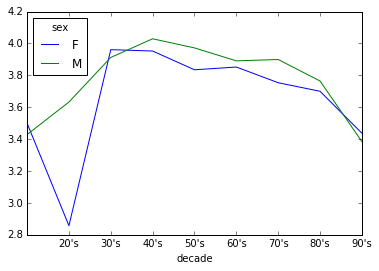

In [56]:
# Let's see movies of which decade were prefered by reviewers by sex
final_lens.pivot_table(
    columns=['sex', ],
    index=[ 'decade'],
    values=[ 'rating'], 
    fill_value=0,
)['rating'].plot()

#%matplotlib inline

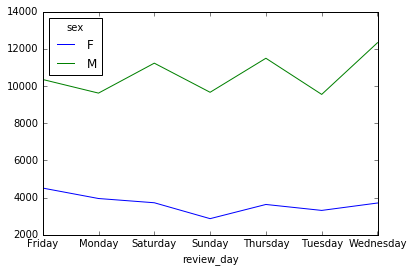

In [57]:
# Is there a specific day the reviewers like to vote ?
final_lens.pivot_table(
    index=['review_day'],
    columns=['sex'],
    values=['rating'],
    aggfunc=len
)['rating'].plot()

# Probably not

In [158]:
import numpy as np 
# Let's see the average rating and num of votes for each movie
rating_count = final_lens.pivot_table(
    index=[ 'decade', 'release_year', 'title',],
    values=['rating', 'idx', ],
    aggfunc={
        'rating': np.average,
        'idx': len,
        
    }
)
rating_count.head(10)
# Notice the nice, hierarchical index on decade and release_year

idx  \
decade release_year title                                                     
       0            unknown                                               9   
20's   1922         Nosferatu (Nosferatu, eine Symphonie des Grauen...   54   
       1926         Scarlet Letter, The (1926)                            2   
30's   1930         Blue Angel, The (Blaue Engel, Der) (1930)            18   
       1931         M (1931)                                             44   
       1932         Farewell to Arms, A (1932)                           12   
       1933         Duck Soup (1933)                                     93   
                    Liebelei (1933)                                       1   
       1934         Gay Divorcee, The (1934)                             15   
                    It Happened One Night (1934)                         81   

                                                                          rating  
decade release_year title                                                         
       0            unknown                                             3.444444  
20's   1922         Nosferatu (Nosferatu, eine Symphonie des Grauen...  3.555556  
       1926         Scarlet Letter, The (1926)                          3.000000  
30's   1930         Blue Angel, The (Blaue Engel, Der) (1930)           3.777778  
       1931         M (1931)                                            4.000000  
       1932         Farewell to Arms, A (1932)                          3.833333  
       1933         Duck Soup (1933)                                    4.000000  
                    Liebelei (1933)                                     1.000000  
       1934         Gay Divorcee, The (1934)                            3.866667  
                    It Happened One Night (1934)                        4.012346

In [159]:
# And now let's find the best movies (rating more than 4) with more than 100 reviews
best_movies = rating_count[(rating_count.idx>100) & (rating_count.rating>4)]
best_movies.head(10)

idx    rating
decade release_year title                                             
30's   1939         Mr. Smith Goes to Washington (1939)  105  4.123810
                    Wizard of Oz, The (1939)             246  4.077236
40's   1940         Philadelphia Story, The (1940)       104  4.115385
       1941         Citizen Kane (1941)                  198  4.292929
                    Maltese Falcon, The (1941)           138  4.210145
       1942         Casablanca (1942)                    243  4.456790
       1944         Arsenic and Old Lace (1944)          115  4.078261
       1946         It's a Wonderful Life (1946)         231  4.121212
50's   1951         African Queen, The (1951)            152  4.184211
       1954         Rear Window (1954)                   209  4.387560

In [166]:
# How many best movies we have each decade?
def xx(x):
    print x
    
best_movies.apply(xx, axis=1)

idx           105
rating    4.12381
Name: (30's, 1939, Mr. Smith Goes to Washington (1939)), dtype: object
idx           246
rating    4.07724
Name: (30's, 1939, Wizard of Oz, The (1939)), dtype: object
idx           104
rating    4.11538
Name: (40's, 1940, Philadelphia Story, The (1940)), dtype: object
idx           198
rating    4.29293
Name: (40's, 1941, Citizen Kane (1941)), dtype: object
idx           138
rating    4.21014
Name: (40's, 1941, Maltese Falcon, The (1941)), dtype: object
idx           243
rating    4.45679
Name: (40's, 1942, Casablanca (1942)), dtype: object
idx           115
rating    4.07826
Name: (40's, 1944, Arsenic and Old Lace (1944)), dtype: object
idx           231
rating    4.12121
Name: (40's, 1946, It's a Wonderful Life (1946)), dtype: object
idx           152
rating    4.18421
Name: (50's, 1951, African Queen, The (1951)), dtype: object
idx           209
rating    4.38756
Name: (50's, 1954, Rear Window (1954)), dtype: object
idx         125
rating    4.344

decade  release_year  title                                                                      
30's    1939          Mr. Smith Goes to Washington (1939)                                            None
                      Wizard of Oz, The (1939)                                                       None
40's    1940          Philadelphia Story, The (1940)                                                 None
        1941          Citizen Kane (1941)                                                            None
                      Maltese Falcon, The (1941)                                                     None
        1942          Casablanca (1942)                                                              None
        1944          Arsenic and Old Lace (1944)                                                    None
        1946          It's a Wonderful Life (1946)                                                   None
50's    1951          African Queen, The (1951)       

In [265]:
droplens[droplens['release_year'] > '1995'].pivot_table(index=['rating'], values=['age'], columns=['sex'] ).dtypes

     sex
age  F      float64
     M      float64
dtype: object

How to use the pivot!

In [266]:
droplens[droplens['release_year'] > '1995'].head().pivot(index='movie_id', columns='age', values='rating')

age,60
movie_id,
15,3
17,4
21,3
22,4
23,5
